# Grid optimisation for renewable enrgy grids using QAOA

The following is an implemetatin of the Quantum Optimisation Approximation Algorithm (QAOA) for solving the Max Cut Problem for a given graph which represents an energy grid. 

The purpose of using the QAOA to solve the Max Cut problem on such a graph is to attempt to optimsie the layout and connectoins used in a renewable energy grid (represented as a graph) so as to minimsie the energy lost. This is done in an attempt to use near-quantum approach to further [Goal 7](https://sdgs.un.org/goals/goal7), afforadable and clean energy for all, of the United Nations (UN) [17 goals](https://sdgs.un.org/goals). The primary reason for attempting to optimise the layout of a renewable energy grid is to ensure that a minimal amount of the renewable energy created is lost as a consequence of transportation and storage of this energy.


This implementation works for graphs of any size (any number of nodes) and encodes the grid system as a grpah where nodes represent either a generator (power producer), consumer (consumes certain amount of power) or neutral node (such as a transformer). The edges of these graphs are wieghted. These weights assigned to each edge represent the resistance of the connection between two given nodes.


All the output of this notebook is in the ```out/``` directory for the sake of readibilty (there are lots of graphs).

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

## Setup

Please note that the edges specified in the ```EDGES``` array are formated as ```(i,j,r)``` for an edge from node `i` to node `j` with resistance `r`.


### The relationship between the weight of an edge in the graph and the resistance of the connection

The relatoinship between the weight of an edge in the graph which represents a grid and the resistance of the connection in the grid is as follows,

$$

w_{i,j} = \frac{1}{r_{i,j}}

$$

where the the weight between nodes $i$ and $j$ is represented by $w_{i,j}$ and the resistance of the connection represented by this edge is given by the $r_{i,j}$ term.


In [ ]:
NUM_LAYERS = 10
STEPS = 250
EDGES = [(0,1, 0.4), (1,2, 0.5), (1,3, 0.8), (1,4, 1)] # edges are formated (i,j,r)

## Build the graph representing the given grid

{(0, 1): Text(-0.15052455474850412, 0.40584123615901735, '2.5'),
 (1, 2): Text(0.424458198576378, 0.26093670157188, '2.0'),
 (1, 3): Text(0.2605709998877723, -0.38023823469361584, '1.4285714285714286'),
 (1, 4): Text(-0.4827509717081062, -0.19227181045370234, '1.0')}

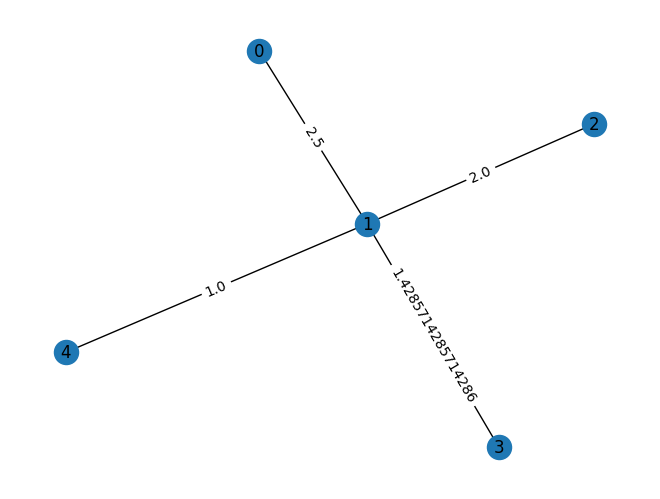

In [5]:
if EDGES == None:
    EDGES = [(0,1)]

if STEPS == None:
    STEPS = 200

if NUM_LAYERS == None:
    NUM_LAYERS = 5

graph = nx.Graph()

for (i,j,r) in EDGES:
    graph.add_edge(i, j, weight=(1/r))

n_wires = len(graph)

pos = nx.spring_layout(graph, seed=7)

nx.draw(graph,pos, with_labels=True)
edge_labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph,pos, edge_labels)

## Defining the cost and mixer Hamiltoians
 
Below the cost Hamiltonian and Mixer Hamiltonian ($ H_M $ / ```mixer_H()```) that are used for the QAOA. It should be noted that the Mixer Hamilitonian is defined as follows, where N is the number of nodes in the grpah:

$$ H_M = X_0 + X_1 + \dots + X_N $$ 

The Cost Hamiltonian ($ H_C $ / ```cost_H()```), is defined slightly differently to the formula usually seen. $ H_C $ is defined as follows, where N again represents the number of nodes in the graph:

$$ H_C = -w_{i,j} (Z_i \otimes Z_j), \;  \forall \; (i,j) \in  EDGES $$

Here the $w_{i,j}$ represents the weight of the edge between nodes $i$ and $j$, the weight of the edge is determined using the resistence and capacity of the edge, *this is further explained in the report*. The cost Hamilitonian is defined in this way (essentially the negatation of usual formula) as a minimising classical optimizer is used, namely a ```GradientDescentOptimizer```. Therefore the optimizer minimises the negated version given Cost Hamiltonian in order to maximise the given Cost Hamiltonian.

In [ ]:
def cost_H():

    coeff = []
    obs = []

    for (i,j,w) in graph.edges:
        coeff.append(w)           # co-eff needs to become weight of edge 
        obs.append((qml.PauliZ(i) @ qml.PauliZ(j)))

    return qml.Hamiltonian(coeff, obs)

def mixer_H():

    coeff = []
    obs = []

    for edge in graph:
        coeff.append(1)
        obs.append(qml.PauliX(edge))

    return qml.Hamiltonian(coeff,obs)

## Defining the QAOA layer, circuit and Cost function

First, we define the ```U_C(gamma)``` and ```U_M(beta)``` which are csot and mixer unitaries which are defined in order to apply the problem and mixer hamiltonians. For more information regarding how these functions are derived, please refer to section 3.1 and 3.3 of the report.

Second, we define a single layer of the QAOA, by defining the function ```qaoa_layer(gamma,beta)```. This function simply applies the Problem Hamiltonian first followed by the Mixer Hamiltonian, using ```U_C(gamma)``` and ```U_M(beta)``` respectively. The alternating of the two unitaries discussed in 3.1 of the report, is achieved when this function is ultimately called in ```ciruit(params)``` multiple times.

Third, we define the circuit to be used for the QAOA by defining the function ```circuit(params)```. Where ```params``` contains $ \gamma $ and $ \beta $ at index 0 and 1 of each row of ```params```, respetively. The function first creates the initial state, which is the superposition of all qubits (achieved by application of the Hadamard gate). This corresponds to step 1 in Section 3.3, Algorithm steps, of the report. The function then proceeds to apply the ```qaoa_layer(gamma,beta)``` function ```NUM_LAYERS``` times, passing in the $ \gamma $ and $ \beta $ values for that layer. This corresponds to step 2 in section 3.3 of the report.

Finally the cost function is defined, which simply calls the ```circuit``` function and returns the expectation cost of the cost Hamiltonian as specified. This corresponds to step 4 in section 3.3 of the report.

In [ ]:
def U_C(gamma):
    # iterate over each pair of edges in the graph and apply
    # the cost unitary using a RZ gate sandwhiched between
    # two CNOT gates, as described in equation 4 of the report 
    # (Section 3.3 step 2)
    for edge in graph.edges:
            wire1 = edge[0]
            wire2 = edge[1]
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(-2*gamma, wires=wire2)
            qml.CNOT(wires=[wire1, wire2])

def U_M(beta):
    # iterate over each node in the graph and apply the
    # the mixer unitary using RX gate on each corresponding wire,
    # as described in equation 5 of the report (Section 3.3 step 2)
     for wire in range(n_wires):
            qml.RX(2 * beta, wires=wire)

def qaoa_layer(gamma,beta):
     # apply the problem Hamilitonian with parameter Gamma
     U_C(gamma)
     # apply the mixer Hamiltonian with parameter Beta
     U_M(beta)

def circuit(params):
    # create the initial state
    for i in range(n_wires):
        qml.Hadamard(i)

    # run the qaoa_layer function, NUM_LAYERS times, passing 2 params needs
    for i in range(NUM_LAYERS):
         qaoa_layer(params[i,0],params[i,1])

# define the device to run the quantum circuit on
dev = qml.device("default.qubit",wires=n_wires)

@qml.qnode(dev)
def cost_function(params):
    # run the circuit with the given parameters (gamma and beta)
    circuit(params)

    # define the cost as the expectation value of the cost Hamilitonian
    return qml.expval(cost_H())